# 1. Data Preprocessing & Cleaning
• Load the dataset using Pandas.

• Clean the text by:

– Lowercasing
– Removing URLs, mentions (@user), hashtags (#), numbers, and special characters

– Handling contractions (e.g., ”don’t” → ”do not”)

– Removing stopwords and lemmatizing words

• Visualize the cleaned data (e.g., word cloud, most frequent words).

In [1]:
import pandas as pd
import numpy as np

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Step 2: Load your dataset
import pandas as pd

# Set the path to your dataset
df = pd.read_csv('/content/drive/MyDrive/trum_tweet_sentiment_analysis.csv')
df.head()


,text,Sentiment
0,RT @JohnLeguizamo: #trump not draining swamp b...,0
1,ICYMI: Hackers Rig FM Radio Stations To Play A...,0
2,Trump protests: LGBTQ rally in New York https:...,1
3,"""Hi I'm Piers Morgan. David Beckham is awful b...",0
4,RT @GlennFranco68: Tech Firm Suing BuzzFeed fo...,0


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


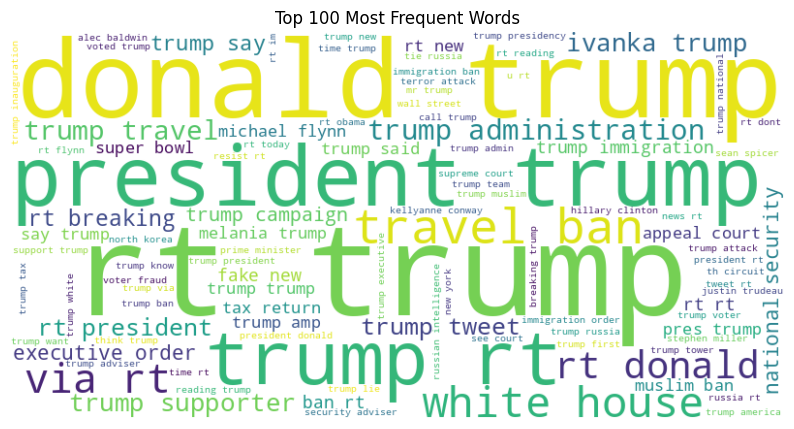

In [4]:
import pandas as pd
import re
import nltk
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')

# Rename columns if needed
df.columns = df.columns.str.lower()

# Clean text function
def preprocess_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    text = re.sub(r"@\w+|#", '', text)
    text = re.sub(r"[^\w\s]", '', text)
    text = re.sub(r"\d+", '', text)
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

# Apply to dataset
df['cleaned_text'] = df['text'].apply(preprocess_text)

#  WordCloud visualization
all_words = ' '.join(df['cleaned_text'])
wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=100).generate(all_words)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Top 100 Most Frequent Words')
plt.show()


# 2. Tokenization & Padding
• Split the dataset into 80% training and 20% testing using train test split.

• Use Keras Tokenizer to convert text into sequences.

• Apply padding to ensure uniform sequence lengths (use percentile-based padding).

Apply 95th percentile-based padding

In [5]:
print(df.columns)
df = df.dropna(subset=['sentiment'])

Index(['text', 'sentiment', 'cleaned_text'], dtype='object')


In [6]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

# Split into train/test before tokenization (important to prevent data leakage)
X = df['cleaned_text']
Y = df['sentiment']  # or df['Sentiment'] if original column name was capitalized

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)

# Tokenizer (fit only on training data)
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

# Convert to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Calculate padding length using 95th percentile
seq_lengths = [len(seq) for seq in X_train_seq]
max_len = int(np.percentile(seq_lengths, 95))

# Apply padding
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post', truncating='post')

print("Max length (95th percentile):", max_len)
print("X_train_pad shape:", X_train_pad.shape)
print("X_test_pad shape:", X_test_pad.shape)


Max length (95th percentile): 16
X_train_pad shape: (1480098, 16)
X_test_pad shape: (370025, 16)


# 3. Model Building
Implement two models:

1. Simple RNN

2. LSTM

Each model should include:

• Embedding Layer (input dim=vocab size, output dim=128)

• Recurrent Layer (SimpleRNN or LSTM with 64 units)

• Dense Layer (sigmoid activation for binary classification)

# Shared Configuration:

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, Dense

# Vocabulary size and other common settings
vocab_size = 10000
embedding_dim = 128
input_length = X_train_pad.shape[1]  # Max length from padding


# Simple RNN Model

In [8]:
# Build Simple RNN model
rnn_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=input_length),
    SimpleRNN(64),
    Dense(1, activation='sigmoid')  # Binary classification
])

rnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
rnn_model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

# LSTM Model

In [9]:
# Build LSTM model
lstm_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=input_length),
    LSTM(64),
    Dense(1, activation='sigmoid')  # Binary classification
])

lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
lstm_model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

# Training & Evaluation
• Compile models with:


– Optimizer: adam

– Metrics: accuracy

• Train for 10 epochs with early stopping.

• Evaluate using:



– Accuracy

– Confusion Matrix

– Classification Report (Precision, Recall, F1-Score)

# Early Stopping

In [10]:
from tensorflow.keras.callbacks import EarlyStopping

# Early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)


# Train and Evaluate: Simple RNN

In [11]:
# Train the RNN model
history_rnn = rnn_model.fit(
    X_train_pad, y_train,
    validation_split=0.2,
    epochs=5,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)

# Evaluate
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import numpy as np

# Predict and round for binary classification
y_pred_rnn = (rnn_model.predict(X_test_pad) > 0.5).astype("int32")

# Print evaluation metrics
print(" RNN Model Evaluation")
print("Accuracy:", accuracy_score(y_test, y_pred_rnn))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rnn))
print("Classification Report:\n", classification_report(y_test, y_pred_rnn))


Epoch 1/5
18502/18502 ━━━━━━━━━━━━━━━━━━━━ 77s 4ms/step - accuracy: 0.9141 - loss: 0.2136 - val_accuracy: 0.9545 - val_loss: 0.1276
Epoch 2/5
18502/18502 ━━━━━━━━━━━━━━━━━━━━ 79s 4ms/step - accuracy: 0.9613 - loss: 0.1094 - val_accuracy: 0.9597 - val_loss: 0.1188
Epoch 3/5
18502/18502 ━━━━━━━━━━━━━━━━━━━━ 93s 4ms/step - accuracy: 0.9689 - loss: 0.0904 - val_accuracy: 0.9611 - val_loss: 0.1129
Epoch 4/5
18502/18502 ━━━━━━━━━━━━━━━━━━━━ 141s 4ms/step - accuracy: 0.9731 - loss: 0.0798 - val_accuracy: 0.9626 - val_loss: 0.1143
Epoch 5/5
18502/18502 ━━━━━━━━━━━━━━━━━━━━ 72s 4ms/step - accuracy: 0.9748 - loss: 0.0750 - val_accuracy: 0.9616 - val_loss: 0.1180
Restoring model weights from the end of the best epoch: 3.
11564/11564 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step
 RNN Model Evaluation
Accuracy: 0.9613701776906965
Confusion Matrix:
 [[240569   8273]
 [  6021 115162]]
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.97      0.97    248

# Train and Evaluate: LSTM

In [12]:
# Train the LSTM model
history_lstm = lstm_model.fit(
    X_train_pad, y_train,
    validation_split=0.2,
    epochs=5,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)

# Predict and round
y_pred_lstm = (lstm_model.predict(X_test_pad) > 0.5).astype("int32")

# Print evaluation metrics
print("LSTM Model Evaluation")
print("Accuracy:", accuracy_score(y_test, y_pred_lstm))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lstm))
print("Classification Report:\n", classification_report(y_test, y_pred_lstm))


Epoch 1/5
18502/18502 ━━━━━━━━━━━━━━━━━━━━ 128s 7ms/step - accuracy: 0.9204 - loss: 0.1977 - val_accuracy: 0.9616 - val_loss: 0.1064
Epoch 2/5
18502/18502 ━━━━━━━━━━━━━━━━━━━━ 121s 7ms/step - accuracy: 0.9673 - loss: 0.0923 - val_accuracy: 0.9682 - val_loss: 0.0932
Epoch 3/5
18502/18502 ━━━━━━━━━━━━━━━━━━━━ 142s 7ms/step - accuracy: 0.9757 - loss: 0.0697 - val_accuracy: 0.9709 - val_loss: 0.0861
Epoch 4/5
18502/18502 ━━━━━━━━━━━━━━━━━━━━ 142s 7ms/step - accuracy: 0.9813 - loss: 0.0546 - val_accuracy: 0.9719 - val_loss: 0.0855
Epoch 5/5
18502/18502 ━━━━━━━━━━━━━━━━━━━━ 138s 6ms/step - accuracy: 0.9848 - loss: 0.0440 - val_accuracy: 0.9719 - val_loss: 0.0909
Restoring model weights from the end of the best epoch: 4.
11564/11564 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step
LSTM Model Evaluation
Accuracy: 0.9720370245253699
Confusion Matrix:
 [[243269   5573]
 [  4774 116409]]
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98   

# Visualization
• Plot training vs. validation loss & accuracy over epochs.
• Compare RNN vs. LSTM performance.

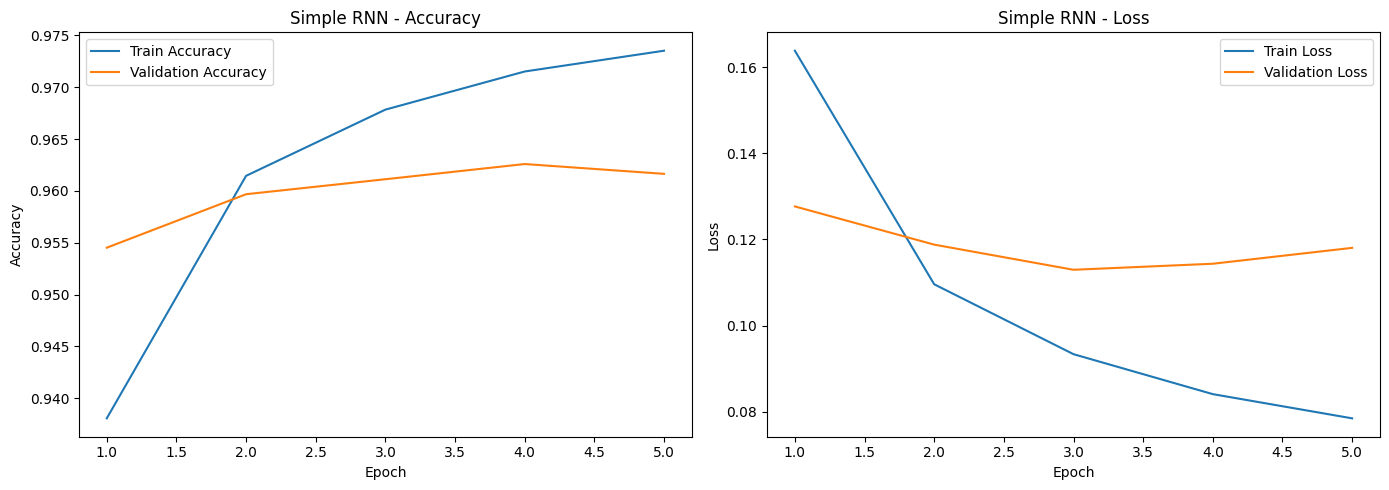

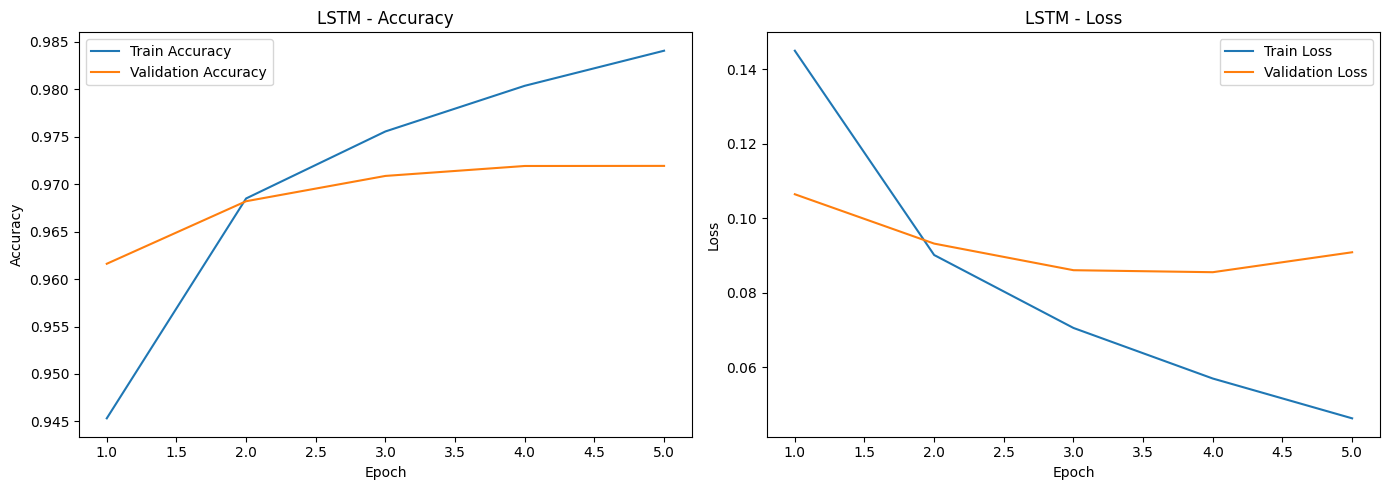

In [13]:
import matplotlib.pyplot as plt

def plot_history(history, title='Model'):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))

    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Train Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Train Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot for RNN
plot_history(history_rnn, title='Simple RNN')

# Plot for LSTM
plot_history(history_lstm, title='LSTM')


# Streamlit GUI

In [14]:
!pip install gradio


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.1/54.1 MB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.1/323.1 kB 32.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 135.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 6.2 MB/s eta 0:00:00


In [15]:
import gradio as gr
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

# Preprocessing function (same as earlier)
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_input(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    text = re.sub(r"@\w+|#", '', text)
    text = re.sub(r"[^\w\s]", '', text)
    text = re.sub(r"\d+", '', text)
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return " ".join(tokens)

# Prediction function
def predict_sentiment(tweet):
    cleaned = preprocess_input(tweet)
    seq = tokenizer.texts_to_sequences([cleaned])
    padded = pad_sequences(seq, maxlen=X_train_pad.shape[1], padding='post', truncating='post')
    prediction = lstm_model.predict(padded)[0][0]
    sentiment = "😊 Positive" if prediction > 0.5 else "☹️ Negative"
    return f"{sentiment} ({prediction:.2f})"

# Gradio interface
interface = gr.Interface(fn=predict_sentiment,
                         inputs="text",
                         outputs="text",
                         title="Twitter Sentiment Predictor",
                         description="Enter a tweet to classify it as positive or negative using LSTM.")

interface.launch()


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://34f8707feeb558d5da.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
